# ARIMA

### Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:

#### 1: Visualize the Time Series Data
#### 2: Make the time series data stationary
#### 3: Plot the Correlation and AutoCorrelation Charts
#### 4: Construct the ARIMA Model
#### 5: Use the model to make predictions
    
Let's go through these steps!

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [115]:
import yfinance as yf

msft = yf.Ticker("TCS") # TCS (Tata Consultancy Services)

# get stock info
msft.info

# get historical market data on daily basis
df = msft.history(start="2021-05-01", end="2022-07-30",interval="1D")

In [116]:
df.drop(['Open','High','Low','Volume','Dividends','Stock Splits'],axis=1,inplace=True)

In [117]:
df.dropna(inplace=True)

# Step 1: Visualize the data

In [118]:
df.tail(5) # we have data till 29 July 2022

,Close
Date,
2022-07-25,7.37
2022-07-26,7.05
2022-07-27,7.30
2022-07-28,7.50
2022-07-29,7.46


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2021-04-30 to 2022-07-29
Data columns (total 1 columns):
Close    315 non-null float64
dtypes: float64(1)
memory usage: 4.9 KB


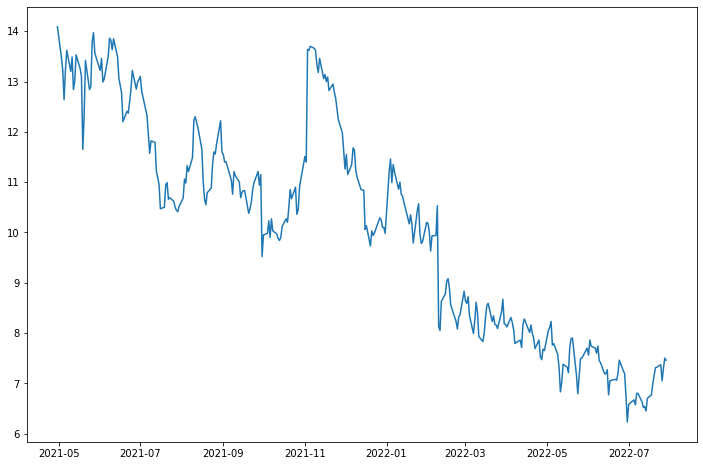

In [120]:
plt.figure(figsize=(12,8))
plt.plot(df)

##### We found graph downward trending over time
##### As we know that, A stationary Time Series is one which characteristics like mean and variance does not change over time
##### Preparing the data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series

In [121]:
rolmean=df.rolling(window=7).mean()
rolstd=df.rolling(window=7).std()

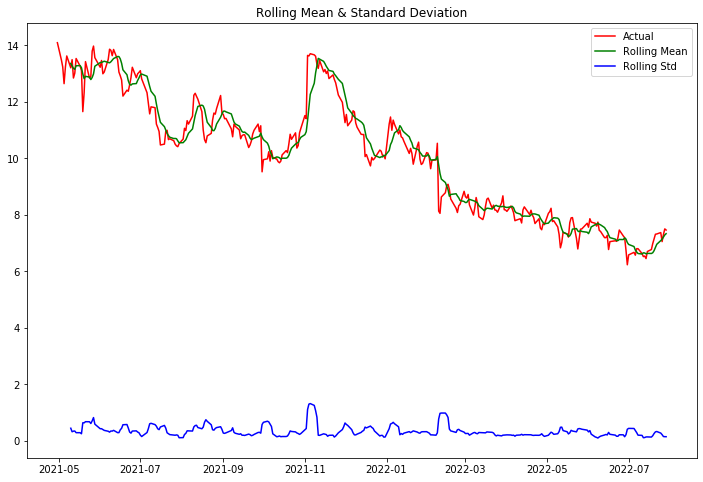

In [122]:
plt.figure(figsize=(12,8))
actual=plt.plot(df,color='red',label='Actual')
rolm=plt.plot(rolmean,color='green',label='Rolling Mean')
rols=plt.plot(rolstd,color='blue',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

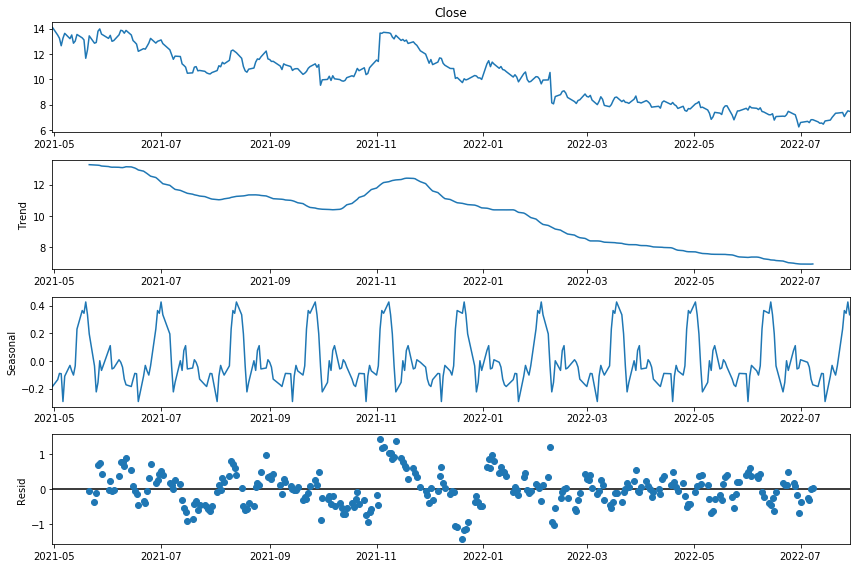

In [123]:
from pylab import rcParams
rcParams['figure.figsize']=(12,8)
decompfreq = 3*10
df_mul_decompose=seasonal_decompose(df.Close,model='additive',period=30)
df_mul_decompose.plot()
plt.show()

### Check for stationarity

In [124]:
from statsmodels.tsa.stattools import adfuller

In [125]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Close):
    rolmean=Close.rolling(window=7).mean()
    rolstd=Close.rolling(window=7).std()
    
    plt.figure(figsize=(12,8))
    actual=plt.plot(Close,color='blue',label='Actual')
    rolm=plt.plot(rolmean,color='green',label='Rolling Mean')
    rols=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

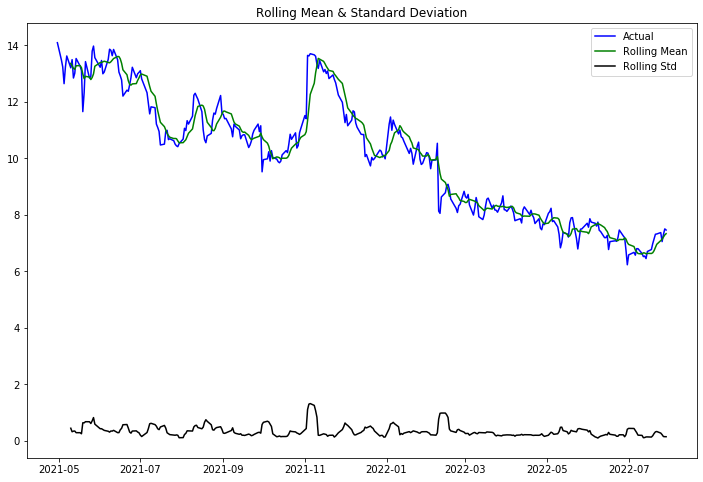

ADF Test Statistic : -1.8731394173684834
p-value : 0.3448007378749944
#Lags Used : 0
Number of Observations Used : 314
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [126]:
adfuller_test(df)

# Step 2: Make the time series data stationary

In [127]:
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

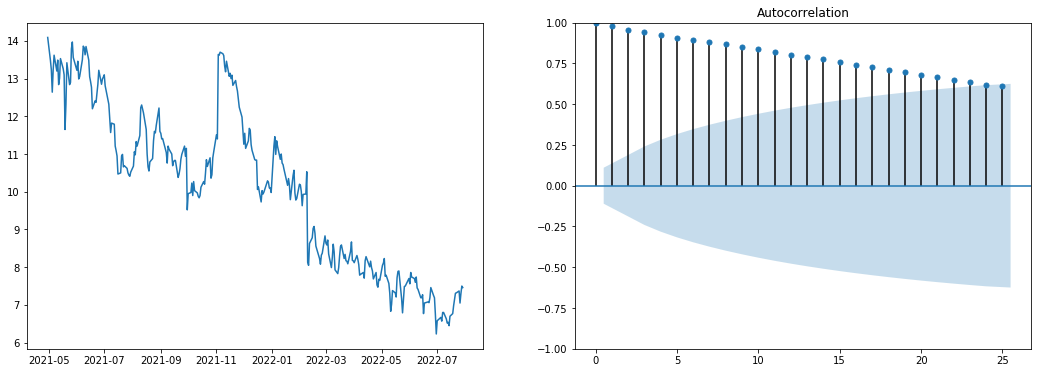

In [128]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(18,6))
ax1.plot(df['Close'])
plot_acf(df['Close'],ax=ax2);
# It is not randomly distributed around mean of 0

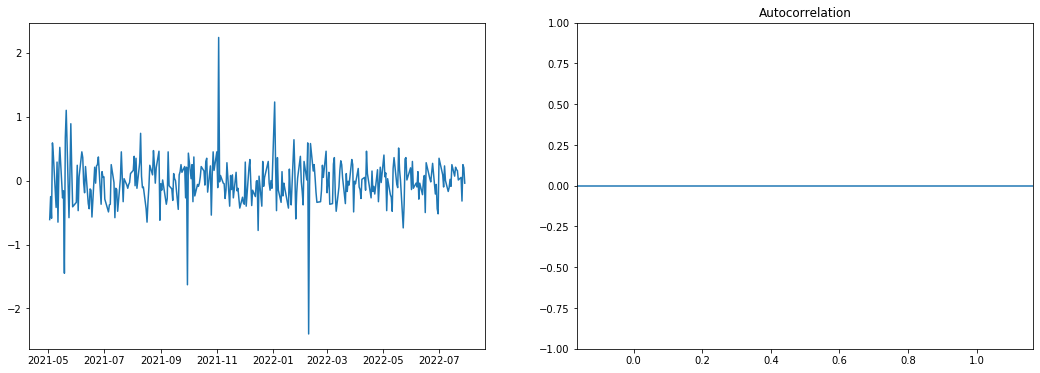

In [129]:
df['diff']=df.Close.diff().dropna()
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(18,6))
ax1.plot(df['diff'])
plot_acf(df['diff'],ax=ax2);

#### It is now randomly distributed around mean of 0, by differencing or shifting 1 times so d=1

In [130]:
ndiffs(df['Close'],test="adf") # ndiffs also suggest taking difference one time, d=1

1

In [131]:
ndiffs(df['diff'].dropna(),test="adf")

0

In [132]:
df.head(5)

,Close,diff
Date,,
2021-04-30,14.09,NaN
2021-05-03,13.48,-0.610001
2021-05-04,13.23,-0.250000
2021-05-05,12.64,-0.589999
2021-05-06,13.23,0.589999


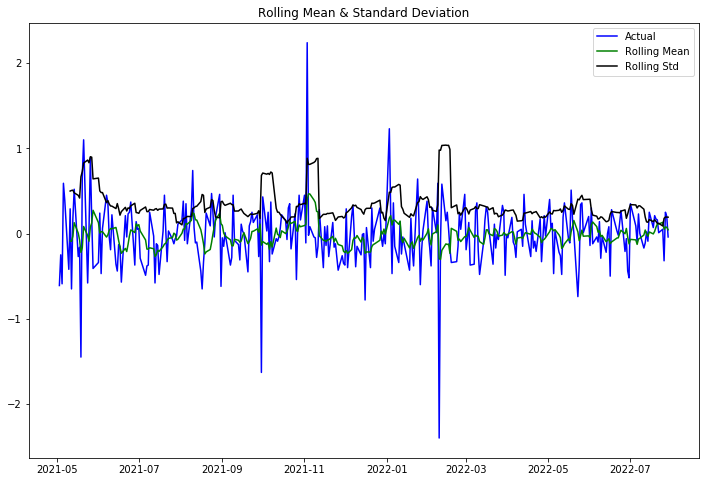

ADF Test Statistic : -18.834731207619022
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 313
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [133]:
adfuller_test(df['diff'].dropna())

##### we removed the trend from the series, it is now stationary

# Step 3: Plot the Correlation and AutoCorrelation Charts

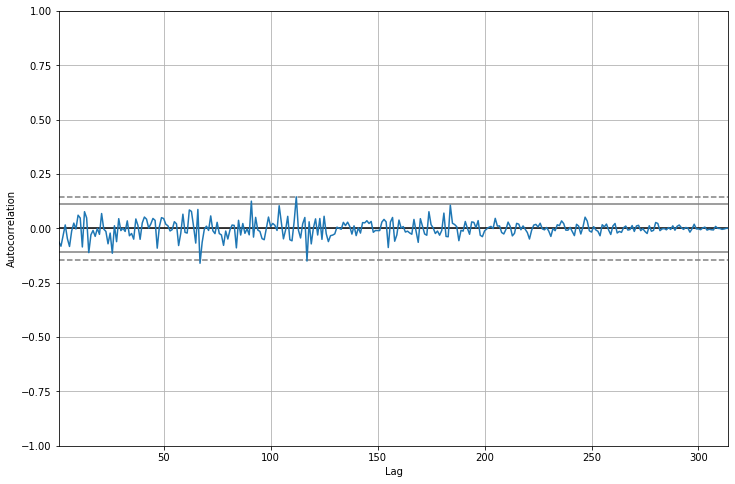

In [134]:
autocorrelation_plot(df['diff'].dropna())
plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

#### Identification of an AR model is often best done with the PACF.
If the data are from an ARIMA( p, d,0) or ARIMA(0, d,q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

### The data may follow an ARIMA( p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

###### -the ACF is exponentially decaying or sinusoidal;
###### -there is a significant spike at lag p in the PACF, but none beyond lag p.


       
### The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

###### -the PACF is exponentially decaying or sinusoidal;
###### -there is a significant spike at lag q in the ACF, but none beyond lag q.

#### p,d,q p AR model lags d differencing q MA lags



In [135]:
import statsmodels.api as sm

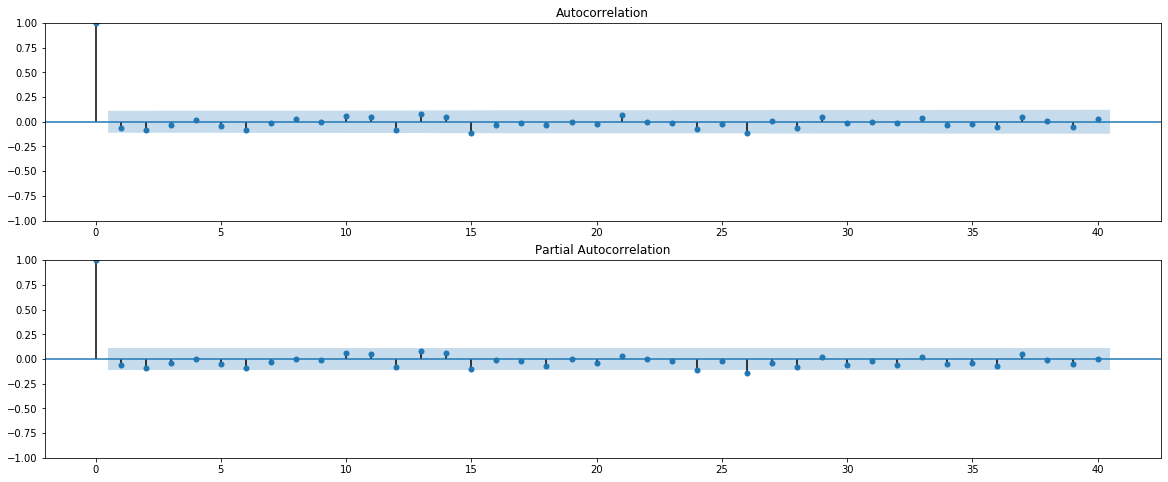

In [136]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['diff'].dropna(),lags=40,ax=ax2)

#### As ACF is exponentially decaying or sinusoidal, we can consider q=0 or q=1 and there is a spike at lag=2 in PACF so p=2.

#### spliting dataset into training and test set

In [137]:
n=int(len(df)*0.8)
train=pd.DataFrame(df.Close[:n])
test=pd.DataFrame(df.Close[n:])

In [138]:
print(len(train))
print(len(test))

252
63


In [139]:
train.tail(5)

,Close
Date,
2022-04-22,7.69
2022-04-25,7.86
2022-04-26,7.53
2022-04-27,7.47
2022-04-28,7.68


# Step 4: Construct the ARIMA Model

In [140]:
train.index = pd.DatetimeIndex(train.index).to_period('D')

In [141]:
model=sm.tsa.arima.ARIMA(train,order=(2,1,0)) # we will fit the model on train set data
result=model.fit()

In [142]:
result.summary()
#coef should not be close to 0 and P>z should not be high

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  252
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -124.267
Date:                Wed, 17 Aug 2022   AIC                            254.535
Time:                        10:43:25   BIC                            265.111
Sample:                    04-30-2021   HQIC                           258.791
                         - 04-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0754      0.072     -1.045      0.296      -0.217       0.066
ar.L2         -0.0819      0.060     -1.359      0.174      -0.200       0.036
sigma2         0.1576      0.007     23.787      0.000       0.145       0.171
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               939.74
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.26
Prob(H) (two-sided):                  0.85   Kurtosis:                        12.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

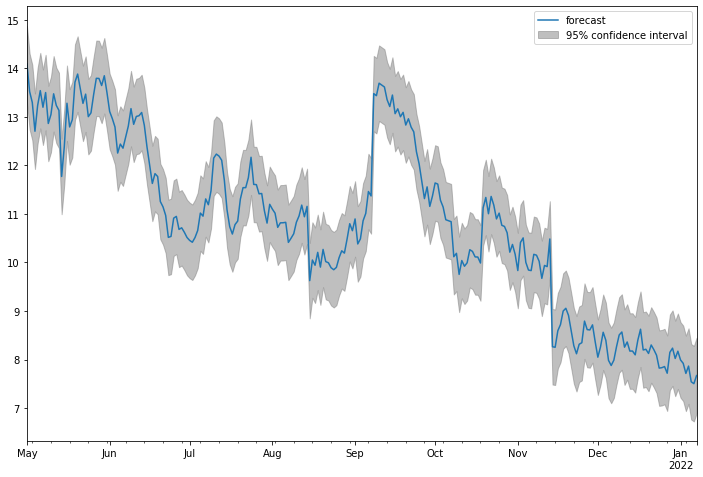

In [143]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(result,start=1,end=252,dynamic=False);

When you set dynamic=True, the model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast. This is called out-of-sample prediction.

When you set dynamic=False, the model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value. This is called in-sample prediction.

Since out-of-sample approach uses the last predicted value from the previous time step to predict the next value in time, as number of steps get farther, it is expected to deviate from actual values because on each step's prediction fitted model learns previous predicted step's errors as well.

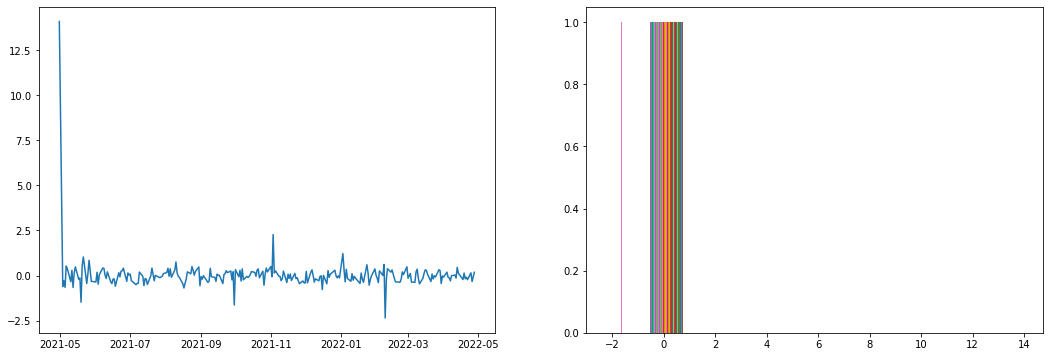

In [144]:
#plot residuals errors
residual=pd.DataFrame(result.resid)
residual.index=residual.index.to_timestamp(freq ='D')
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(18,6))
ax1.plot(residual)
ax2.hist(residual);

#### above plot concludes that residuals does not vary with time or residuals is distributed around mean of 0, so we don't need to consider the residuals further

# Step 5: Use the model to make predictions

#### prediction on test set to measure accuracy of model

In [145]:
train.index=train.index.to_timestamp(freq ='D')

#### We are creating dataset which has date index, and date value is starting after train set

In [146]:
from pandas.tseries.offsets import DateOffset
future_dates = [train.index[-1]+DateOffset(days=x) for x in range(0,90)]

In [147]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=test.columns)

#### as we have next 90 days, but we need only 63 business days as we have data only for 63 days in test set

In [148]:
future_dataset_df=future_dataset_df.asfreq("B")

In [149]:
future_dataset_df['Close']=test.Close

In [150]:
future_dataset_df['forecast']=result.forecast(63).to_numpy() # predicting next 63 days values

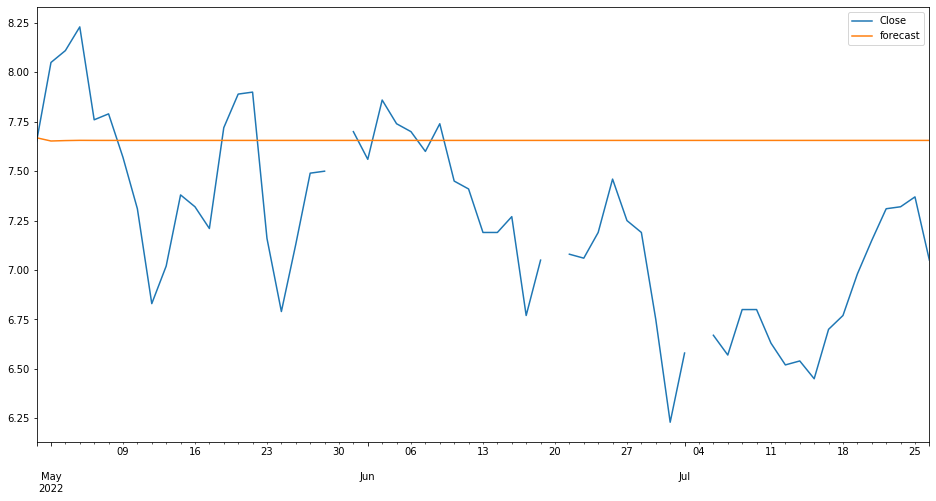

In [151]:
future_dataset_df[['Close', 'forecast']].plot(figsize=(16,8))

In [152]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [153]:
y_pred=result.forecast(63).to_numpy()
y_actual=test.to_numpy()

In [154]:
MAPE(y_actual,y_pred)

7.068980256490197

#### prediction for future 30 days

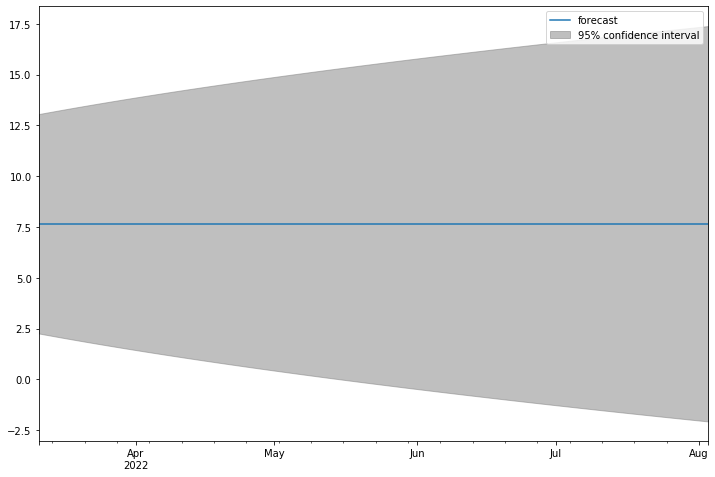

In [155]:
plot_predict(result,start=315,end=460,dynamic=True); 